In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 10

In [3]:
y1_step = .02
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-10] = 1e-10
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [70]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.001, 2000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 2000: PDE Error: 0.106316738584; False Transient Error: 0.106308387133; Iterations: 41; CG Error: 0.000000000096
Episode 2000: PDE Error: 0.106316443121; False Transient Error: 0.106308095780; Iterations: 41; CG Error: 0.000000000093
Episode 2000: PDE Error: 0.106312247172; False Transient Error: 0.106303879695; Iterations: 41; CG Error: 0.000000000074
Episode 2000: PDE Error: 0.106310961576; False Transient Error: 0.106302585376; Iterations: 41; CG Error: 0.000000000072
Episode 2000: PDE Error: 0.106315621437; False Transient Error: 0.106307290002; Iterations: 41; CG Error: 0.000000000086
Episode 2000: PDE Error: 0.106317121570; False Transient Error: 0.106308809217; Iterations: 42; CG Error: 0.000000000090
Episode 2000: PDE Error: 0.106316959630; False Transient Error: 0.106308627221; Iterations: 42; CG Error: 0.000000000074
Episode 2000: PDE Error: 0.106314130714; False Transient Error: 0.106305790287; Iterations: 41; CG Error: 0.000000000079
Episode 2000: PDE Error: 0.10631

In [12]:
# np.save(f"v_list_{λ}", ϕ_list)
# np.save(f"e_list_{λ}", ems_list)
ems_list = np.load("e_list_10.npy")
ϕ_list = np.load("v_list_10.npy")

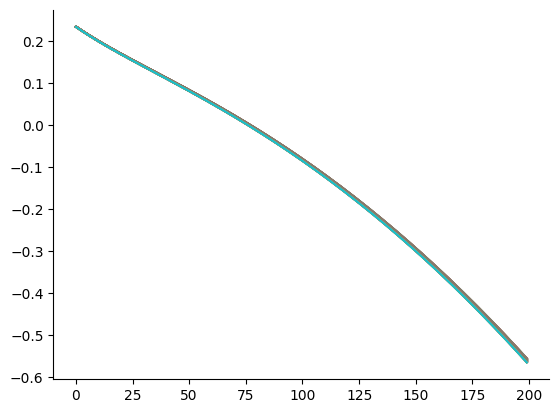

In [7]:
plt.plot(ϕ_list[0])
plt.show()

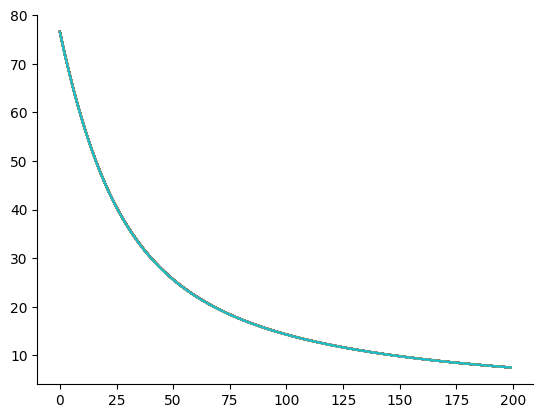

In [13]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

$$
\log N = \begin{cases} 
\gamma_1 y_1 + \frac{\gamma_2}{2} y_1 ^2, \text{ if } y_1 \le \tilde{y_1} \\
\gamma_1 (y_1 - \tilde{y_1} + \bar{y_1}) + \frac{\gamma_2}{2} (y_1 - \tilde{y_1} + \bar{y_1})^2
+ \frac{\gamma_3}{2} (y_1 - \tilde{y_1})^2, \text{ if } y_1 \geq \tilde{y_1} \end{cases}
$$

In [14]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1.
ϵ = 0.001
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.01 + ems_old * 0.99
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.065688861252	 rhs error: 0.064037739699
Episode: 2	 lhs error: 0.069150012391	 rhs error: 0.070437380758
Episode: 3	 lhs error: 0.078390926349	 rhs error: 0.079698261302
Episode: 4	 lhs error: 0.085036799641	 rhs error: 0.086360335302
Episode: 5	 lhs error: 0.090128437004	 rhs error: 0.091464888420
Episode: 6	 lhs error: 0.094186246412	 rhs error: 0.095532521436
Episode: 7	 lhs error: 0.097508159072	 rhs error: 0.098861190033
Episode: 8	 lhs error: 0.100280695343	 rhs error: 0.101637453158
Episode: 9	 lhs error: 0.102628151088	 rhs error: 0.103985888449
Episode: 10	 lhs error: 0.104637085685	 rhs error: 0.105993821812
Episode: 11	 lhs error: 0.106369649586	 rhs error: 0.107724836291
Episode: 12	 lhs error: 0.107871477383	 rhs error: 0.109226665994
Episode: 13	 lhs error: 0.109176823639	 rhs error: 0.110536062272
Episode: 14	 lhs error: 0.110312298772	 rhs error: 0.111681925812
Episode: 15	 lhs error: 0.111299791029	 rhs error: 0.112687394398
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.106073537379	 rhs error: 0.106080628805
Episode: 126	 lhs error: 0.106128972401	 rhs error: 0.106139353884
Episode: 127	 lhs error: 0.106183222903	 rhs error: 0.106197230182
Episode: 128	 lhs error: 0.106236819451	 rhs error: 0.106253964164
Episode: 129	 lhs error: 0.106294751113	 rhs error: 0.106315451125
Episode: 130	 lhs error: 0.106355411076	 rhs error: 0.106377390039
Episode: 131	 lhs error: 0.106416400465	 rhs error: 0.106437368684
Episode: 132	 lhs error: 0.106477191500	 rhs error: 0.106541861269
Episode: 133	 lhs error: 0.106532127142	 rhs error: 0.106619086576
Episode: 134	 lhs error: 0.106541434742	 rhs error: 0.106625681927
Episode: 135	 lhs error: 0.106493692207	 rhs error: 0.106574740234
Episode: 136	 lhs error: 0.106410284426	 rhs error: 0.106488160852
Episode: 137	 lhs error: 0.106316059290	 rhs error: 0.106390849996
Episode: 138	 lhs error: 0.106232049094	 rhs error: 0.106303430309
Episode: 139	 lhs error: 0.106169456089	 rhs error: 0.10623654

Episode: 248	 lhs error: 0.104753839135	 rhs error: 0.104756757838
Episode: 249	 lhs error: 0.104747582981	 rhs error: 0.104750219107
Episode: 250	 lhs error: 0.104741006822	 rhs error: 0.104743384886
Episode: 251	 lhs error: 0.104734352979	 rhs error: 0.104736467895
Episode: 252	 lhs error: 0.104727759608	 rhs error: 0.104729583777
Episode: 253	 lhs error: 0.104720988232	 rhs error: 0.104722511521
Episode: 254	 lhs error: 0.104713768028	 rhs error: 0.104715014165
Episode: 255	 lhs error: 0.104706274663	 rhs error: 0.104707271929
Episode: 256	 lhs error: 0.104698917608	 rhs error: 0.104699661724
Episode: 257	 lhs error: 0.104691680303	 rhs error: 0.104692136400
Episode: 258	 lhs error: 0.104684081433	 rhs error: 0.104684228032
Episode: 259	 lhs error: 0.104675918704	 rhs error: 0.104675785085
Episode: 260	 lhs error: 0.104667651803	 rhs error: 0.104667291613
Episode: 261	 lhs error: 0.104659744517	 rhs error: 0.104659178093
Episode: 262	 lhs error: 0.104651915899	 rhs error: 0.10465110

Episode: 371	 lhs error: 0.104114570775	 rhs error: 0.104102658232
Episode: 372	 lhs error: 0.104189867106	 rhs error: 0.104069888979
Episode: 373	 lhs error: 0.103668347126	 rhs error: 0.103656115973
Episode: 374	 lhs error: 0.103778068747	 rhs error: 0.103896393151
Episode: 375	 lhs error: 0.104163196710	 rhs error: 0.104204614687
Episode: 376	 lhs error: 0.104411054398	 rhs error: 0.104279661177
Episode: 377	 lhs error: 0.103659987816	 rhs error: 0.103640084534
Episode: 378	 lhs error: 0.103767661258	 rhs error: 0.103930511251
Episode: 379	 lhs error: 0.104194032102	 rhs error: 0.104314519453
Episode: 380	 lhs error: 0.104598754086	 rhs error: 0.104462340053
Episode: 381	 lhs error: 0.103640714506	 rhs error: 0.103612471256
Episode: 382	 lhs error: 0.103739165520	 rhs error: 0.103941574329
Episode: 383	 lhs error: 0.104185059841	 rhs error: 0.104387375760
Episode: 384	 lhs error: 0.104741482058	 rhs error: 0.104607092181
Episode: 385	 lhs error: 0.103605918732	 rhs error: 0.10356864

Episode: 494	 lhs error: 0.109270345417	 rhs error: 0.110140660090
Episode: 495	 lhs error: 0.112704555867	 rhs error: 0.111243723127
Episode: 496	 lhs error: 0.104455254590	 rhs error: 0.104620918639
Episode: 497	 lhs error: 0.105614548196	 rhs error: 0.107246303911
Episode: 498	 lhs error: 0.108267049338	 rhs error: 0.110156585106
Episode: 499	 lhs error: 0.112861452880	 rhs error: 0.111795738498
Episode: 500	 lhs error: 0.103938627891	 rhs error: 0.103489670336
Episode: 501	 lhs error: 0.104035767196	 rhs error: 0.105313487399
Episode: 502	 lhs error: 0.105742463582	 rhs error: 0.107797066690
Episode: 503	 lhs error: 0.109782103909	 rhs error: 0.109447678960
Episode: 504	 lhs error: 0.106921240044	 rhs error: 0.106194520661
Episode: 505	 lhs error: 0.103363452757	 rhs error: 0.103683137475
Episode: 506	 lhs error: 0.103681237715	 rhs error: 0.104186911967
Episode: 507	 lhs error: 0.105449105279	 rhs error: 0.105477238282
Episode: 508	 lhs error: 0.106022508948	 rhs error: 0.10585175

Episode: 617	 lhs error: 0.107531094430	 rhs error: 0.106428482351
Episode: 618	 lhs error: 0.104551594251	 rhs error: 0.104757139146
Episode: 619	 lhs error: 0.105572846680	 rhs error: 0.106825676972
Episode: 620	 lhs error: 0.108840468560	 rhs error: 0.108930160688
Episode: 621	 lhs error: 0.110607667867	 rhs error: 0.109330821054
Episode: 622	 lhs error: 0.103584664450	 rhs error: 0.103819041203
Episode: 623	 lhs error: 0.104779152904	 rhs error: 0.106115392275
Episode: 624	 lhs error: 0.107636851400	 rhs error: 0.108552740226
Episode: 625	 lhs error: 0.110538157184	 rhs error: 0.109625235550
Episode: 626	 lhs error: 0.102916163479	 rhs error: 0.102764867168
Episode: 627	 lhs error: 0.102581941962	 rhs error: 0.103106784817
Episode: 628	 lhs error: 0.103916046184	 rhs error: 0.104340591269
Episode: 629	 lhs error: 0.105449710229	 rhs error: 0.104984769053
Episode: 630	 lhs error: 0.103610177326	 rhs error: 0.104268040126
Episode: 631	 lhs error: 0.103876111963	 rhs error: 0.10483583

Episode: 740	 lhs error: 0.102881632600	 rhs error: 0.102643096880
Episode: 741	 lhs error: 0.103188756418	 rhs error: 0.104307794968
Episode: 742	 lhs error: 0.104479674702	 rhs error: 0.106368670807
Episode: 743	 lhs error: 0.107862314394	 rhs error: 0.107752794231
Episode: 744	 lhs error: 0.106178211679	 rhs error: 0.105357131941
Episode: 745	 lhs error: 0.103403705936	 rhs error: 0.103599735017
Episode: 746	 lhs error: 0.104354824554	 rhs error: 0.105342951407
Episode: 747	 lhs error: 0.106778974124	 rhs error: 0.107209145604
Episode: 748	 lhs error: 0.108692097754	 rhs error: 0.107795772614
Episode: 749	 lhs error: 0.103040697272	 rhs error: 0.103253372133
Episode: 750	 lhs error: 0.104051235086	 rhs error: 0.105258540807
Episode: 751	 lhs error: 0.106206372783	 rhs error: 0.107447742471
Episode: 752	 lhs error: 0.109233028886	 rhs error: 0.108548046833
Episode: 753	 lhs error: 0.102435406298	 rhs error: 0.102568472170
Episode: 754	 lhs error: 0.103102517774	 rhs error: 0.10429739

Episode: 863	 lhs error: 0.100996689788	 rhs error: 0.101073146061
Episode: 864	 lhs error: 0.101253935426	 rhs error: 0.101601914910
Episode: 865	 lhs error: 0.101893534982	 rhs error: 0.102275111057
Episode: 866	 lhs error: 0.102783580379	 rhs error: 0.102634666687
Episode: 867	 lhs error: 0.100863147858	 rhs error: 0.100832627376
Episode: 868	 lhs error: 0.100924628802	 rhs error: 0.101277254338
Episode: 869	 lhs error: 0.101363114509	 rhs error: 0.101872137420
Episode: 870	 lhs error: 0.102368016333	 rhs error: 0.102305706745
Episode: 871	 lhs error: 0.101831409550	 rhs error: 0.101616563940
Episode: 872	 lhs error: 0.100924157619	 rhs error: 0.100985030117
Episode: 873	 lhs error: 0.101239080444	 rhs error: 0.101451054549
Episode: 874	 lhs error: 0.101926021456	 rhs error: 0.102025446316
Episode: 875	 lhs error: 0.102365455548	 rhs error: 0.102182915947
Episode: 876	 lhs error: 0.100677508613	 rhs error: 0.100742096638
Episode: 877	 lhs error: 0.100895154648	 rhs error: 0.10116415

Episode: 986	 lhs error: 0.099534459594	 rhs error: 0.099485435096
Episode: 987	 lhs error: 0.099537417049	 rhs error: 0.099485408414
Episode: 988	 lhs error: 0.099512693075	 rhs error: 0.099460692516
Episode: 989	 lhs error: 0.099496492093	 rhs error: 0.099452147272
Episode: 990	 lhs error: 0.099496756984	 rhs error: 0.099448265224
Episode: 991	 lhs error: 0.099499685217	 rhs error: 0.099448359826
Episode: 992	 lhs error: 0.099493713706	 rhs error: 0.099441711237
Episode: 993	 lhs error: 0.099473341154	 rhs error: 0.099425720749
Episode: 994	 lhs error: 0.099464536305	 rhs error: 0.099417716575
Episode: 995	 lhs error: 0.099464381767	 rhs error: 0.099414133007
Episode: 996	 lhs error: 0.099464632183	 rhs error: 0.099413043211
Episode: 997	 lhs error: 0.099455275477	 rhs error: 0.099403374779
Episode: 998	 lhs error: 0.099440400463	 rhs error: 0.099391207019
Episode: 999	 lhs error: 0.099432745229	 rhs error: 0.099383805832
Episode: 1000	 lhs error: 0.099432110833	 rhs error: 0.0993807

Episode: 1107	 lhs error: 0.098781524121	 rhs error: 0.098728082782
Episode: 1108	 lhs error: 0.098775824203	 rhs error: 0.098722366090
Episode: 1109	 lhs error: 0.098770131630	 rhs error: 0.098716656713
Episode: 1110	 lhs error: 0.098764444735	 rhs error: 0.098710953110
Episode: 1111	 lhs error: 0.098758763308	 rhs error: 0.098705255039
Episode: 1112	 lhs error: 0.098753088204	 rhs error: 0.098699563214
Episode: 1113	 lhs error: 0.098747419316	 rhs error: 0.098693877542
Episode: 1114	 lhs error: 0.098741756093	 rhs error: 0.098688197634
Episode: 1115	 lhs error: 0.098736099123	 rhs error: 0.098682524101
Episode: 1116	 lhs error: 0.098730449058	 rhs error: 0.098676857416
Episode: 1117	 lhs error: 0.098724804784	 rhs error: 0.098671196387
Episode: 1118	 lhs error: 0.098719164953	 rhs error: 0.098665539845
Episode: 1119	 lhs error: 0.098713530712	 rhs error: 0.098659889076
Episode: 1120	 lhs error: 0.098707904243	 rhs error: 0.098654246118
Episode: 1121	 lhs error: 0.098702284912	 rhs er

Episode: 1228	 lhs error: 0.098129662618	 rhs error: 0.098074287556
Episode: 1229	 lhs error: 0.098124532957	 rhs error: 0.098069142684
Episode: 1230	 lhs error: 0.098119406074	 rhs error: 0.098064000643
Episode: 1231	 lhs error: 0.098114283197	 rhs error: 0.098058862644
Episode: 1232	 lhs error: 0.098109164684	 rhs error: 0.098053728988
Episode: 1233	 lhs error: 0.098104049269	 rhs error: 0.098048598395
Episode: 1234	 lhs error: 0.098098935724	 rhs error: 0.098043469690
Episode: 1235	 lhs error: 0.098093824622	 rhs error: 0.098038343495
Episode: 1236	 lhs error: 0.098088717573	 rhs error: 0.098033221395
Episode: 1237	 lhs error: 0.098083614991	 rhs error: 0.098028103738
Episode: 1238	 lhs error: 0.098078515547	 rhs error: 0.098022989181
Episode: 1239	 lhs error: 0.098073417954	 rhs error: 0.098017876491
Episode: 1240	 lhs error: 0.098068322545	 rhs error: 0.098012766044
Episode: 1241	 lhs error: 0.098063230698	 rhs error: 0.098007659201
Episode: 1242	 lhs error: 0.098058143095	 rhs er

Episode: 1349	 lhs error: 0.097527457367	 rhs error: 0.097470337530
Episode: 1350	 lhs error: 0.097522594935	 rhs error: 0.097465461495
Episode: 1351	 lhs error: 0.097517734196	 rhs error: 0.097460587166
Episode: 1352	 lhs error: 0.097512875270	 rhs error: 0.097455714649
Episode: 1353	 lhs error: 0.097508017522	 rhs error: 0.097450843310
Episode: 1354	 lhs error: 0.097503160440	 rhs error: 0.097445972660
Episode: 1355	 lhs error: 0.097498304396	 rhs error: 0.097441103086
Episode: 1356	 lhs error: 0.097493450121	 rhs error: 0.097436235298
Episode: 1357	 lhs error: 0.097488597654	 rhs error: 0.097431369313
Episode: 1358	 lhs error: 0.097483746270	 rhs error: 0.097426504405
Episode: 1359	 lhs error: 0.097478895483	 rhs error: 0.097421640116
Episode: 1360	 lhs error: 0.097474045685	 rhs error: 0.097416776856
Episode: 1361	 lhs error: 0.097469197570	 rhs error: 0.097411915301
Episode: 1362	 lhs error: 0.097464351172	 rhs error: 0.097407055458
Episode: 1363	 lhs error: 0.097459505861	 rhs er

Episode: 1470	 lhs error: 0.096946195477	 rhs error: 0.096887535807
Episode: 1471	 lhs error: 0.096941433936	 rhs error: 0.096882762489
Episode: 1472	 lhs error: 0.096936672540	 rhs error: 0.096877989349
Episode: 1473	 lhs error: 0.096931911747	 rhs error: 0.096873216843
Episode: 1474	 lhs error: 0.096927151853	 rhs error: 0.096868445243
Episode: 1475	 lhs error: 0.096922392549	 rhs error: 0.096863674232
Episode: 1476	 lhs error: 0.096917633376	 rhs error: 0.096858903368
Episode: 1477	 lhs error: 0.096912874387	 rhs error: 0.096854132722
Episode: 1478	 lhs error: 0.096908116008	 rhs error: 0.096849362711
Episode: 1479	 lhs error: 0.096903358414	 rhs error: 0.096844593491
Episode: 1480	 lhs error: 0.096898601349	 rhs error: 0.096839824807
Episode: 1481	 lhs error: 0.096893844522	 rhs error: 0.096835056379
Episode: 1482	 lhs error: 0.096889087952	 rhs error: 0.096830288234
Episode: 1483	 lhs error: 0.096884331890	 rhs error: 0.096825520620
Episode: 1484	 lhs error: 0.096879576493	 rhs er

Episode: 1591	 lhs error: 0.096372947024	 rhs error: 0.096312990748
Episode: 1592	 lhs error: 0.096368230865	 rhs error: 0.096308264969
Episode: 1593	 lhs error: 0.096363514983	 rhs error: 0.096303539488
Episode: 1594	 lhs error: 0.096358799466	 rhs error: 0.096298814390
Episode: 1595	 lhs error: 0.096354084372	 rhs error: 0.096294089732
Episode: 1596	 lhs error: 0.096349369627	 rhs error: 0.096289365440
Episode: 1597	 lhs error: 0.096344655128	 rhs error: 0.096284641414
Episode: 1598	 lhs error: 0.096339940911	 rhs error: 0.096279917690
Episode: 1599	 lhs error: 0.096335227105	 rhs error: 0.096275194395
Episode: 1600	 lhs error: 0.096330513729	 rhs error: 0.096270471546
Episode: 1601	 lhs error: 0.096325800666	 rhs error: 0.096265749027
Episode: 1602	 lhs error: 0.096321087840	 rhs error: 0.096261026767
Episode: 1603	 lhs error: 0.096316375332	 rhs error: 0.096256304844
Episode: 1604	 lhs error: 0.096311663259	 rhs error: 0.096251583375
Episode: 1605	 lhs error: 0.096306951599	 rhs er

Episode: 1712	 lhs error: 0.095804953365	 rhs error: 0.095743966485
Episode: 1713	 lhs error: 0.095800284179	 rhs error: 0.095739289891
Episode: 1714	 lhs error: 0.095795615401	 rhs error: 0.095734613723
Episode: 1715	 lhs error: 0.095790947088	 rhs error: 0.095729938042
Episode: 1716	 lhs error: 0.095786279290	 rhs error: 0.095725262892
Episode: 1717	 lhs error: 0.095781611970	 rhs error: 0.095720588234
Episode: 1718	 lhs error: 0.095776945079	 rhs error: 0.095715914025
Episode: 1719	 lhs error: 0.095772278643	 rhs error: 0.095711240290
Episode: 1720	 lhs error: 0.095767612708	 rhs error: 0.095706567075
Episode: 1721	 lhs error: 0.095762947256	 rhs error: 0.095701894358
Episode: 1722	 lhs error: 0.095758282243	 rhs error: 0.095697222099
Episode: 1723	 lhs error: 0.095753617696	 rhs error: 0.095692550323
Episode: 1724	 lhs error: 0.095748953657	 rhs error: 0.095687879074
Episode: 1725	 lhs error: 0.095744290106	 rhs error: 0.095683208331
Episode: 1726	 lhs error: 0.095739627004	 rhs er

Episode: 1833	 lhs error: 0.095243743184	 rhs error: 0.095181986362
Episode: 1834	 lhs error: 0.095239140194	 rhs error: 0.095177378034
Episode: 1835	 lhs error: 0.095234537845	 rhs error: 0.095172770361
Episode: 1836	 lhs error: 0.095229936129	 rhs error: 0.095168163338
Episode: 1837	 lhs error: 0.095225335029	 rhs error: 0.095163556947
Episode: 1838	 lhs error: 0.095220734547	 rhs error: 0.095158951190
Episode: 1839	 lhs error: 0.095216134715	 rhs error: 0.095154346101
Episode: 1840	 lhs error: 0.095211535553	 rhs error: 0.095149741697
Episode: 1841	 lhs error: 0.095206937038	 rhs error: 0.095145137956
Episode: 1842	 lhs error: 0.095202339135	 rhs error: 0.095140534840
Episode: 1843	 lhs error: 0.095197741842	 rhs error: 0.095135932352
Episode: 1844	 lhs error: 0.095193145204	 rhs error: 0.095131330536
Episode: 1845	 lhs error: 0.095188549240	 rhs error: 0.095126729411
Episode: 1846	 lhs error: 0.095183953933	 rhs error: 0.095122128957
Episode: 1847	 lhs error: 0.095179359261	 rhs er

Episode: 1954	 lhs error: 0.094691702678	 rhs error: 0.094629411364
Episode: 1955	 lhs error: 0.094687184269	 rhs error: 0.094624889429
Episode: 1956	 lhs error: 0.094682666639	 rhs error: 0.094620368286
Episode: 1957	 lhs error: 0.094678149785	 rhs error: 0.094615847931
Episode: 1958	 lhs error: 0.094673633681	 rhs error: 0.094611328339
Episode: 1959	 lhs error: 0.094669118313	 rhs error: 0.094606809498
Episode: 1960	 lhs error: 0.094664603703	 rhs error: 0.094602291429
Episode: 1961	 lhs error: 0.094660089875	 rhs error: 0.094597774156
Episode: 1962	 lhs error: 0.094655576823	 rhs error: 0.094593257672
Episode: 1963	 lhs error: 0.094651064525	 rhs error: 0.094588741955
Episode: 1964	 lhs error: 0.094646552971	 rhs error: 0.094584226997
Episode: 1965	 lhs error: 0.094642042181	 rhs error: 0.094579712815
Episode: 1966	 lhs error: 0.094637532169	 rhs error: 0.094575199426
Episode: 1967	 lhs error: 0.094633022936	 rhs error: 0.094570686830
Episode: 1968	 lhs error: 0.094628514466	 rhs er

Episode: 2075	 lhs error: 0.094150668265	 rhs error: 0.094088044433
Episode: 2076	 lhs error: 0.094146246039	 rhs error: 0.094083620205
Episode: 2077	 lhs error: 0.094141824631	 rhs error: 0.094079196806
Episode: 2078	 lhs error: 0.094137404044	 rhs error: 0.094074774238
Episode: 2079	 lhs error: 0.094132984278	 rhs error: 0.094070352503
Episode: 2080	 lhs error: 0.094128565338	 rhs error: 0.094065931607
Episode: 2081	 lhs error: 0.094124147224	 rhs error: 0.094061511548
Episode: 2082	 lhs error: 0.094119729933	 rhs error: 0.094057092322
Episode: 2083	 lhs error: 0.094115313463	 rhs error: 0.094052673928
Episode: 2084	 lhs error: 0.094110897818	 rhs error: 0.094048256372
Episode: 2085	 lhs error: 0.094106483002	 rhs error: 0.094043839655
Episode: 2086	 lhs error: 0.094102069010	 rhs error: 0.094039423774
Episode: 2087	 lhs error: 0.094097655839	 rhs error: 0.094035008725
Episode: 2088	 lhs error: 0.094093243486	 rhs error: 0.094030594506
Episode: 2089	 lhs error: 0.094088831964	 rhs er

Episode: 2196	 lhs error: 0.093621606353	 rhs error: 0.093558818170
Episode: 2197	 lhs error: 0.093617284862	 rhs error: 0.093554495935
Episode: 2198	 lhs error: 0.093612964207	 rhs error: 0.093550174544
Episode: 2199	 lhs error: 0.093608644388	 rhs error: 0.093545853998
Episode: 2200	 lhs error: 0.093604325405	 rhs error: 0.093541534298
Episode: 2201	 lhs error: 0.093600007260	 rhs error: 0.093537215445
Episode: 2202	 lhs error: 0.093595689948	 rhs error: 0.093532897435
Episode: 2203	 lhs error: 0.093591373469	 rhs error: 0.093528580267
Episode: 2204	 lhs error: 0.093587057826	 rhs error: 0.093524263944
Episode: 2205	 lhs error: 0.093582743025	 rhs error: 0.093519948472
Episode: 2206	 lhs error: 0.093578429061	 rhs error: 0.093515633847
Episode: 2207	 lhs error: 0.093574115924	 rhs error: 0.093511320058
Episode: 2208	 lhs error: 0.093569803618	 rhs error: 0.093507007109
Episode: 2209	 lhs error: 0.093565492152	 rhs error: 0.093502695009
Episode: 2210	 lhs error: 0.093561181531	 rhs er

Episode: 2317	 lhs error: 0.093104743911	 rhs error: 0.093041929314
Episode: 2318	 lhs error: 0.093100522666	 rhs error: 0.093037708350
Episode: 2319	 lhs error: 0.093096302239	 rhs error: 0.093033488213
Episode: 2320	 lhs error: 0.093092082622	 rhs error: 0.093029268893
Episode: 2321	 lhs error: 0.093087863818	 rhs error: 0.093025050394
Episode: 2322	 lhs error: 0.093083645836	 rhs error: 0.093020832725
Episode: 2323	 lhs error: 0.093079428676	 rhs error: 0.093016615885
Episode: 2324	 lhs error: 0.093075212328	 rhs error: 0.093012399865
Episode: 2325	 lhs error: 0.093070996787	 rhs error: 0.093008184660
Episode: 2326	 lhs error: 0.093066782059	 rhs error: 0.093003970275
Episode: 2327	 lhs error: 0.093062568156	 rhs error: 0.092999756722
Episode: 2328	 lhs error: 0.093058355073	 rhs error: 0.092995543997
Episode: 2329	 lhs error: 0.093054142800	 rhs error: 0.092991332089
Episode: 2330	 lhs error: 0.093049931332	 rhs error: 0.092987120994
Episode: 2331	 lhs error: 0.093045720679	 rhs er

Episode: 2438	 lhs error: 0.092599825898	 rhs error: 0.092537097422
Episode: 2439	 lhs error: 0.092595701482	 rhs error: 0.092532974126
Episode: 2440	 lhs error: 0.092591577852	 rhs error: 0.092528851623
Episode: 2441	 lhs error: 0.092587455005	 rhs error: 0.092524729908
Episode: 2442	 lhs error: 0.092583332938	 rhs error: 0.092520608980
Episode: 2443	 lhs error: 0.092579211649	 rhs error: 0.092516488836
Episode: 2444	 lhs error: 0.092575091139	 rhs error: 0.092512369477
Episode: 2445	 lhs error: 0.092570971407	 rhs error: 0.092508250902
Episode: 2446	 lhs error: 0.092566852460	 rhs error: 0.092504133119
Episode: 2447	 lhs error: 0.092562734295	 rhs error: 0.092500016124
Episode: 2448	 lhs error: 0.092558616910	 rhs error: 0.092495899915
Episode: 2449	 lhs error: 0.092554500300	 rhs error: 0.092491784486
Episode: 2450	 lhs error: 0.092550384464	 rhs error: 0.092487669838
Episode: 2451	 lhs error: 0.092546269408	 rhs error: 0.092483555977
Episode: 2452	 lhs error: 0.092542155136	 rhs er

Episode: 2559	 lhs error: 0.092106353861	 rhs error: 0.092043803419
Episode: 2560	 lhs error: 0.092102321673	 rhs error: 0.092039773036
Episode: 2561	 lhs error: 0.092098290225	 rhs error: 0.092035743399
Episode: 2562	 lhs error: 0.092094259518	 rhs error: 0.092031714507
Episode: 2563	 lhs error: 0.092090229550	 rhs error: 0.092027686361
Episode: 2564	 lhs error: 0.092086200326	 rhs error: 0.092023658964
Episode: 2565	 lhs error: 0.092082171844	 rhs error: 0.092019632313
Episode: 2566	 lhs error: 0.092078144102	 rhs error: 0.092015606407
Episode: 2567	 lhs error: 0.092074117099	 rhs error: 0.092011581245
Episode: 2568	 lhs error: 0.092070090835	 rhs error: 0.092007556827
Episode: 2569	 lhs error: 0.092066065311	 rhs error: 0.092003533155
Episode: 2570	 lhs error: 0.092062040527	 rhs error: 0.091999510228
Episode: 2571	 lhs error: 0.092058016483	 rhs error: 0.091995488046
Episode: 2572	 lhs error: 0.092053993176	 rhs error: 0.091991466605
Episode: 2573	 lhs error: 0.092049970606	 rhs er

Episode: 2680	 lhs error: 0.091623753185	 rhs error: 0.091561456134
Episode: 2681	 lhs error: 0.091619808452	 rhs error: 0.091557513770
Episode: 2682	 lhs error: 0.091615864426	 rhs error: 0.091553572116
Episode: 2683	 lhs error: 0.091611921103	 rhs error: 0.091549631172
Episode: 2684	 lhs error: 0.091607978484	 rhs error: 0.091545690933
Episode: 2685	 lhs error: 0.091604036563	 rhs error: 0.091541751399
Episode: 2686	 lhs error: 0.091600095345	 rhs error: 0.091537812570
Episode: 2687	 lhs error: 0.091596154831	 rhs error: 0.091533874451
Episode: 2688	 lhs error: 0.091592215021	 rhs error: 0.091529937038
Episode: 2689	 lhs error: 0.091588275912	 rhs error: 0.091526000332
Episode: 2690	 lhs error: 0.091584337504	 rhs error: 0.091522064331
Episode: 2691	 lhs error: 0.091580399795	 rhs error: 0.091518129032
Episode: 2692	 lhs error: 0.091576462787	 rhs error: 0.091514194438
Episode: 2693	 lhs error: 0.091572526480	 rhs error: 0.091510260551
Episode: 2694	 lhs error: 0.091568590875	 rhs er

Episode: 2801	 lhs error: 0.091151464853	 rhs error: 0.091089483148
Episode: 2802	 lhs error: 0.091147603152	 rhs error: 0.091085624279
Episode: 2803	 lhs error: 0.091143742121	 rhs error: 0.091081766085
Episode: 2804	 lhs error: 0.091139881761	 rhs error: 0.091077908563
Episode: 2805	 lhs error: 0.091136022066	 rhs error: 0.091074051710
Episode: 2806	 lhs error: 0.091132163036	 rhs error: 0.091070195527
Episode: 2807	 lhs error: 0.091128304678	 rhs error: 0.091066340018
Episode: 2808	 lhs error: 0.091124446988	 rhs error: 0.091062485182
Episode: 2809	 lhs error: 0.091120589967	 rhs error: 0.091058631017
Episode: 2810	 lhs error: 0.091116733609	 rhs error: 0.091054777519
Episode: 2811	 lhs error: 0.091112877919	 rhs error: 0.091050924692
Episode: 2812	 lhs error: 0.091109022897	 rhs error: 0.091047072537
Episode: 2813	 lhs error: 0.091105168541	 rhs error: 0.091043221051
Episode: 2814	 lhs error: 0.091101314852	 rhs error: 0.091039370234
Episode: 2815	 lhs error: 0.091097461825	 rhs er

Episode: 2922	 lhs error: 0.090688980416	 rhs error: 0.090627365017
Episode: 2923	 lhs error: 0.090685197775	 rhs error: 0.090623585588
Episode: 2924	 lhs error: 0.090681415773	 rhs error: 0.090619806801
Episode: 2925	 lhs error: 0.090677634407	 rhs error: 0.090616028655
Episode: 2926	 lhs error: 0.090673853677	 rhs error: 0.090612251147
Episode: 2927	 lhs error: 0.090670073586	 rhs error: 0.090608474280
Episode: 2928	 lhs error: 0.090666294131	 rhs error: 0.090604698052
Episode: 2929	 lhs error: 0.090662515314	 rhs error: 0.090600922465
Episode: 2930	 lhs error: 0.090658737133	 rhs error: 0.090597147517
Episode: 2931	 lhs error: 0.090654959589	 rhs error: 0.090593373208
Episode: 2932	 lhs error: 0.090651182680	 rhs error: 0.090589599538
Episode: 2933	 lhs error: 0.090647406407	 rhs error: 0.090585826506
Episode: 2934	 lhs error: 0.090643630769	 rhs error: 0.090582054112
Episode: 2935	 lhs error: 0.090639855767	 rhs error: 0.090578282357
Episode: 2936	 lhs error: 0.090636081401	 rhs er

Episode: 3043	 lhs error: 0.090235844346	 rhs error: 0.090174637056
Episode: 3044	 lhs error: 0.090232137191	 rhs error: 0.090170933426
Episode: 3045	 lhs error: 0.090228430651	 rhs error: 0.090167230412
Episode: 3046	 lhs error: 0.090224724719	 rhs error: 0.090163528010
Episode: 3047	 lhs error: 0.090221019394	 rhs error: 0.090159826216
Episode: 3048	 lhs error: 0.090217314676	 rhs error: 0.090156125032
Episode: 3049	 lhs error: 0.090213610567	 rhs error: 0.090152424459
Episode: 3050	 lhs error: 0.090209907071	 rhs error: 0.090148724501
Episode: 3051	 lhs error: 0.090206204183	 rhs error: 0.090145025154
Episode: 3052	 lhs error: 0.090202501903	 rhs error: 0.090141326417
Episode: 3053	 lhs error: 0.090198800230	 rhs error: 0.090137628289
Episode: 3054	 lhs error: 0.090195099164	 rhs error: 0.090133930770
Episode: 3055	 lhs error: 0.090191398706	 rhs error: 0.090130233863
Episode: 3056	 lhs error: 0.090187698858	 rhs error: 0.090126537566
Episode: 3057	 lhs error: 0.090183999616	 rhs er

Episode: 3164	 lhs error: 0.089791643459	 rhs error: 0.089730878330
Episode: 3165	 lhs error: 0.089788008519	 rhs error: 0.089727247167
Episode: 3166	 lhs error: 0.089784374163	 rhs error: 0.089723616591
Episode: 3167	 lhs error: 0.089780740391	 rhs error: 0.089719986600
Episode: 3168	 lhs error: 0.089777107203	 rhs error: 0.089716357194
Episode: 3169	 lhs error: 0.089773474600	 rhs error: 0.089712728375
Episode: 3170	 lhs error: 0.089769842580	 rhs error: 0.089709100142
Episode: 3171	 lhs error: 0.089766211140	 rhs error: 0.089705472490
Episode: 3172	 lhs error: 0.089762580281	 rhs error: 0.089701845420
Episode: 3173	 lhs error: 0.089758950005	 rhs error: 0.089698218936
Episode: 3174	 lhs error: 0.089755320314	 rhs error: 0.089694593039
Episode: 3175	 lhs error: 0.089751691206	 rhs error: 0.089690967727
Episode: 3176	 lhs error: 0.089748062677	 rhs error: 0.089687342995
Episode: 3177	 lhs error: 0.089744434730	 rhs error: 0.089683718847
Episode: 3178	 lhs error: 0.089740807364	 rhs er

Episode: 3285	 lhs error: 0.089355994962	 rhs error: 0.089295699457
Episode: 3286	 lhs error: 0.089352429175	 rhs error: 0.089292137650
Episode: 3287	 lhs error: 0.089348863949	 rhs error: 0.089288576404
Episode: 3288	 lhs error: 0.089345299279	 rhs error: 0.089285015717
Episode: 3289	 lhs error: 0.089341735168	 rhs error: 0.089281455590
Episode: 3290	 lhs error: 0.089338171616	 rhs error: 0.089277896023
Episode: 3291	 lhs error: 0.089334608622	 rhs error: 0.089274337016
Episode: 3292	 lhs error: 0.089331046187	 rhs error: 0.089270778569
Episode: 3293	 lhs error: 0.089327484310	 rhs error: 0.089267220682
Episode: 3294	 lhs error: 0.089323922993	 rhs error: 0.089263663356
Episode: 3295	 lhs error: 0.089320362231	 rhs error: 0.089260106587
Episode: 3296	 lhs error: 0.089316802027	 rhs error: 0.089256550377
Episode: 3297	 lhs error: 0.089313242379	 rhs error: 0.089252994724
Episode: 3298	 lhs error: 0.089309683289	 rhs error: 0.089249439630
Episode: 3299	 lhs error: 0.089306124754	 rhs er

Episode: 3406	 lhs error: 0.088928538183	 rhs error: 0.088868734142
Episode: 3407	 lhs error: 0.088925038645	 rhs error: 0.088865238743
Episode: 3408	 lhs error: 0.088921539643	 rhs error: 0.088861743880
Episode: 3409	 lhs error: 0.088918041177	 rhs error: 0.088858249556
Episode: 3410	 lhs error: 0.088914543246	 rhs error: 0.088854755767
Episode: 3411	 lhs error: 0.088911045849	 rhs error: 0.088851262513
Episode: 3412	 lhs error: 0.088907548988	 rhs error: 0.088847769796
Episode: 3413	 lhs error: 0.088904052660	 rhs error: 0.088844277614
Episode: 3414	 lhs error: 0.088900556869	 rhs error: 0.088840785970
Episode: 3415	 lhs error: 0.088897061614	 rhs error: 0.088837294863
Episode: 3416	 lhs error: 0.088893566892	 rhs error: 0.088833804290
Episode: 3417	 lhs error: 0.088890072702	 rhs error: 0.088830314250
Episode: 3418	 lhs error: 0.088886579047	 rhs error: 0.088826824747
Episode: 3419	 lhs error: 0.088883085926	 rhs error: 0.088823335778
Episode: 3420	 lhs error: 0.088879593340	 rhs er

Episode: 3527	 lhs error: 0.088508930454	 rhs error: 0.088449634913
Episode: 3528	 lhs error: 0.088505494404	 rhs error: 0.088446203125
Episode: 3529	 lhs error: 0.088502058867	 rhs error: 0.088442771850
Episode: 3530	 lhs error: 0.088498623843	 rhs error: 0.088439341090
Episode: 3531	 lhs error: 0.088495189332	 rhs error: 0.088435910843
Episode: 3532	 lhs error: 0.088491755335	 rhs error: 0.088432481111
Episode: 3533	 lhs error: 0.088488321850	 rhs error: 0.088429051893
Episode: 3534	 lhs error: 0.088484888877	 rhs error: 0.088425623187
Episode: 3535	 lhs error: 0.088481456417	 rhs error: 0.088422194994
Episode: 3536	 lhs error: 0.088478024470	 rhs error: 0.088418767316
Episode: 3537	 lhs error: 0.088474593036	 rhs error: 0.088415340152
Episode: 3538	 lhs error: 0.088471162113	 rhs error: 0.088411913499
Episode: 3539	 lhs error: 0.088467731700	 rhs error: 0.088408487357
Episode: 3540	 lhs error: 0.088464301799	 rhs error: 0.088405061729
Episode: 3541	 lhs error: 0.088460872412	 rhs er

Episode: 3648	 lhs error: 0.088096845869	 rhs error: 0.088038071829
Episode: 3649	 lhs error: 0.088093470682	 rhs error: 0.088034700997
Episode: 3650	 lhs error: 0.088090095988	 rhs error: 0.088031330658
Episode: 3651	 lhs error: 0.088086721786	 rhs error: 0.088027960811
Episode: 3652	 lhs error: 0.088083348076	 rhs error: 0.088024591457
Episode: 3653	 lhs error: 0.088079974857	 rhs error: 0.088021222596
Episode: 3654	 lhs error: 0.088076602131	 rhs error: 0.088017854227
Episode: 3655	 lhs error: 0.088073229896	 rhs error: 0.088014486350
Episode: 3656	 lhs error: 0.088069858153	 rhs error: 0.088011118966
Episode: 3657	 lhs error: 0.088066486901	 rhs error: 0.088007752073
Episode: 3658	 lhs error: 0.088063116139	 rhs error: 0.088004385672
Episode: 3659	 lhs error: 0.088059745869	 rhs error: 0.088001019762
Episode: 3660	 lhs error: 0.088056376091	 rhs error: 0.087997654345
Episode: 3661	 lhs error: 0.088053006802	 rhs error: 0.087994289418
Episode: 3662	 lhs error: 0.088049638005	 rhs er

Episode: 3769	 lhs error: 0.087691975510	 rhs error: 0.087633732568
Episode: 3770	 lhs error: 0.087688658705	 rhs error: 0.087630420184
Episode: 3771	 lhs error: 0.087685342374	 rhs error: 0.087627108275
Episode: 3772	 lhs error: 0.087682026516	 rhs error: 0.087623796838
Episode: 3773	 lhs error: 0.087678711129	 rhs error: 0.087620485874
Episode: 3774	 lhs error: 0.087675396214	 rhs error: 0.087617175381
Episode: 3775	 lhs error: 0.087672081772	 rhs error: 0.087613865362
Episode: 3776	 lhs error: 0.087668767802	 rhs error: 0.087610555815
Episode: 3777	 lhs error: 0.087665454302	 rhs error: 0.087607246740
Episode: 3778	 lhs error: 0.087662141273	 rhs error: 0.087603938135
Episode: 3779	 lhs error: 0.087658828716	 rhs error: 0.087600630003
Episode: 3780	 lhs error: 0.087655516632	 rhs error: 0.087597322344
Episode: 3781	 lhs error: 0.087652205018	 rhs error: 0.087594015156
Episode: 3782	 lhs error: 0.087648893875	 rhs error: 0.087590708439
Episode: 3783	 lhs error: 0.087645583202	 rhs er

Episode: 3890	 lhs error: 0.087294027893	 rhs error: 0.087236322754
Episode: 3891	 lhs error: 0.087290767136	 rhs error: 0.087233066462
Episode: 3892	 lhs error: 0.087287506833	 rhs error: 0.087229810626
Episode: 3893	 lhs error: 0.087284246985	 rhs error: 0.087226555244
Episode: 3894	 lhs error: 0.087280987590	 rhs error: 0.087223300315
Episode: 3895	 lhs error: 0.087277728647	 rhs error: 0.087220045839
Episode: 3896	 lhs error: 0.087274470157	 rhs error: 0.087216791817
Episode: 3897	 lhs error: 0.087271212122	 rhs error: 0.087213538248
Episode: 3898	 lhs error: 0.087267954539	 rhs error: 0.087210285133
Episode: 3899	 lhs error: 0.087264697409	 rhs error: 0.087207032471
Episode: 3900	 lhs error: 0.087261440731	 rhs error: 0.087203780261
Episode: 3901	 lhs error: 0.087258184507	 rhs error: 0.087200528505
Episode: 3902	 lhs error: 0.087254928734	 rhs error: 0.087197277201
Episode: 3903	 lhs error: 0.087251673414	 rhs error: 0.087194026350
Episode: 3904	 lhs error: 0.087248418546	 rhs er

Episode: 4011	 lhs error: 0.086902728955	 rhs error: 0.086845565921
Episode: 4012	 lhs error: 0.086899522052	 rhs error: 0.086842363510
Episode: 4013	 lhs error: 0.086896315584	 rhs error: 0.086839161535
Episode: 4014	 lhs error: 0.086893109553	 rhs error: 0.086835959996
Episode: 4015	 lhs error: 0.086889903960	 rhs error: 0.086832758896
Episode: 4016	 lhs error: 0.086886698802	 rhs error: 0.086829558231
Episode: 4017	 lhs error: 0.086883494079	 rhs error: 0.086826358001
Episode: 4018	 lhs error: 0.086880289792	 rhs error: 0.086823158207
Episode: 4019	 lhs error: 0.086877085939	 rhs error: 0.086819958848
Episode: 4020	 lhs error: 0.086873882523	 rhs error: 0.086816759925
Episode: 4021	 lhs error: 0.086870679542	 rhs error: 0.086813561438
Episode: 4022	 lhs error: 0.086867476996	 rhs error: 0.086810363385
Episode: 4023	 lhs error: 0.086864274885	 rhs error: 0.086807165768
Episode: 4024	 lhs error: 0.086861073208	 rhs error: 0.086803968585
Episode: 4025	 lhs error: 0.086857871966	 rhs er

Episode: 4132	 lhs error: 0.086517821595	 rhs error: 0.086461202950
Episode: 4133	 lhs error: 0.086514666489	 rhs error: 0.086458052348
Episode: 4134	 lhs error: 0.086511511803	 rhs error: 0.086454902166
Episode: 4135	 lhs error: 0.086508357537	 rhs error: 0.086451752403
Episode: 4136	 lhs error: 0.086505203691	 rhs error: 0.086448603061
Episode: 4137	 lhs error: 0.086502050263	 rhs error: 0.086445454137
Episode: 4138	 lhs error: 0.086498897256	 rhs error: 0.086442305633
Episode: 4139	 lhs error: 0.086495744668	 rhs error: 0.086439157549
Episode: 4140	 lhs error: 0.086492592498	 rhs error: 0.086436009883
Episode: 4141	 lhs error: 0.086489440747	 rhs error: 0.086432862637
Episode: 4142	 lhs error: 0.086486289416	 rhs error: 0.086429715809
Episode: 4143	 lhs error: 0.086483138502	 rhs error: 0.086426569400
Episode: 4144	 lhs error: 0.086479988009	 rhs error: 0.086423423410
Episode: 4145	 lhs error: 0.086476837932	 rhs error: 0.086420277838
Episode: 4146	 lhs error: 0.086473688275	 rhs er

Episode: 4253	 lhs error: 0.086139064741	 rhs error: 0.086082991090
Episode: 4254	 lhs error: 0.086135959505	 rhs error: 0.086079890356
Episode: 4255	 lhs error: 0.086132854672	 rhs error: 0.086076790025
Episode: 4256	 lhs error: 0.086129750242	 rhs error: 0.086073690098
Episode: 4257	 lhs error: 0.086126646218	 rhs error: 0.086070590577
Episode: 4258	 lhs error: 0.086123542598	 rhs error: 0.086067491459
Episode: 4259	 lhs error: 0.086120439382	 rhs error: 0.086064392745
Episode: 4260	 lhs error: 0.086117336569	 rhs error: 0.086061294435
Episode: 4261	 lhs error: 0.086114234161	 rhs error: 0.086058196528
Episode: 4262	 lhs error: 0.086111132155	 rhs error: 0.086055099025
Episode: 4263	 lhs error: 0.086108030554	 rhs error: 0.086052001925
Episode: 4264	 lhs error: 0.086104929354	 rhs error: 0.086048905228
Episode: 4265	 lhs error: 0.086101828559	 rhs error: 0.086045808935
Episode: 4266	 lhs error: 0.086098728167	 rhs error: 0.086042713044
Episode: 4267	 lhs error: 0.086095628178	 rhs er

Episode: 4374	 lhs error: 0.085766232157	 rhs error: 0.085710702718
Episode: 4375	 lhs error: 0.085763174977	 rhs error: 0.085707650028
Episode: 4376	 lhs error: 0.085760118188	 rhs error: 0.085704597730
Episode: 4377	 lhs error: 0.085757061787	 rhs error: 0.085701545820
Episode: 4378	 lhs error: 0.085754005777	 rhs error: 0.085698494300
Episode: 4379	 lhs error: 0.085750950155	 rhs error: 0.085695443169
Episode: 4380	 lhs error: 0.085747894924	 rhs error: 0.085692392427
Episode: 4381	 lhs error: 0.085744840081	 rhs error: 0.085689342075
Episode: 4382	 lhs error: 0.085741785628	 rhs error: 0.085686292112
Episode: 4383	 lhs error: 0.085738731564	 rhs error: 0.085683242538
Episode: 4384	 lhs error: 0.085735677890	 rhs error: 0.085680193353
Episode: 4385	 lhs error: 0.085732624603	 rhs error: 0.085677144555
Episode: 4386	 lhs error: 0.085729571705	 rhs error: 0.085674096147
Episode: 4387	 lhs error: 0.085726519197	 rhs error: 0.085671048128
Episode: 4388	 lhs error: 0.085723467077	 rhs er

Episode: 4495	 lhs error: 0.085399111213	 rhs error: 0.085344124014
Episode: 4496	 lhs error: 0.085396100385	 rhs error: 0.085341117656
Episode: 4497	 lhs error: 0.085393089934	 rhs error: 0.085338111676
Episode: 4498	 lhs error: 0.085390079859	 rhs error: 0.085335106070
Episode: 4499	 lhs error: 0.085387070160	 rhs error: 0.085332100841
Episode: 4500	 lhs error: 0.085384060838	 rhs error: 0.085329095989
Episode: 4501	 lhs error: 0.085381051891	 rhs error: 0.085326091511
Episode: 4502	 lhs error: 0.085378043320	 rhs error: 0.085323087409
Episode: 4503	 lhs error: 0.085375035124	 rhs error: 0.085320083681
Episode: 4504	 lhs error: 0.085372027303	 rhs error: 0.085317080329
Episode: 4505	 lhs error: 0.085369019858	 rhs error: 0.085314077352
Episode: 4506	 lhs error: 0.085366012788	 rhs error: 0.085311074751
Episode: 4507	 lhs error: 0.085363006094	 rhs error: 0.085308072525
Episode: 4508	 lhs error: 0.085359999775	 rhs error: 0.085305070674
Episode: 4509	 lhs error: 0.085356993830	 rhs er

Episode: 4616	 lhs error: 0.085037501565	 rhs error: 0.084983053671
Episode: 4617	 lhs error: 0.085034535482	 rhs error: 0.084980092030
Episode: 4618	 lhs error: 0.085031569763	 rhs error: 0.084977130753
Episode: 4619	 lhs error: 0.085028604408	 rhs error: 0.084974169840
Episode: 4620	 lhs error: 0.085025639415	 rhs error: 0.084971209289
Episode: 4621	 lhs error: 0.085022674785	 rhs error: 0.084968249101
Episode: 4622	 lhs error: 0.085019710520	 rhs error: 0.084965289277
Episode: 4623	 lhs error: 0.085016746616	 rhs error: 0.084962329814
Episode: 4624	 lhs error: 0.085013783074	 rhs error: 0.084959370714
Episode: 4625	 lhs error: 0.085010819896	 rhs error: 0.084956411976
Episode: 4626	 lhs error: 0.085007857080	 rhs error: 0.084953453600
Episode: 4627	 lhs error: 0.085004894626	 rhs error: 0.084950495586
Episode: 4628	 lhs error: 0.085001932535	 rhs error: 0.084947537935
Episode: 4629	 lhs error: 0.084998970806	 rhs error: 0.084944580645
Episode: 4630	 lhs error: 0.084996009440	 rhs er

Episode: 4737	 lhs error: 0.084681214025	 rhs error: 0.084627301730
Episode: 4738	 lhs error: 0.084678291169	 rhs error: 0.084624383283
Episode: 4739	 lhs error: 0.084675368664	 rhs error: 0.084621465186
Episode: 4740	 lhs error: 0.084672446509	 rhs error: 0.084618547440
Episode: 4741	 lhs error: 0.084669524704	 rhs error: 0.084615630043
Episode: 4742	 lhs error: 0.084666603251	 rhs error: 0.084612712998
Episode: 4743	 lhs error: 0.084663682148	 rhs error: 0.084609796303
Episode: 4744	 lhs error: 0.084660761397	 rhs error: 0.084606879959
Episode: 4745	 lhs error: 0.084657840996	 rhs error: 0.084603963965
Episode: 4746	 lhs error: 0.084654920945	 rhs error: 0.084601048321
Episode: 4747	 lhs error: 0.084652001245	 rhs error: 0.084598133027
Episode: 4748	 lhs error: 0.084649081894	 rhs error: 0.084595218082
Episode: 4749	 lhs error: 0.084646162894	 rhs error: 0.084592303488
Episode: 4750	 lhs error: 0.084643244244	 rhs error: 0.084589389244
Episode: 4751	 lhs error: 0.084640325945	 rhs er

Episode: 4858	 lhs error: 0.084330069619	 rhs error: 0.084276688567
Episode: 4859	 lhs error: 0.084327188548	 rhs error: 0.084273811867
Episode: 4860	 lhs error: 0.084324307816	 rhs error: 0.084270935506
Episode: 4861	 lhs error: 0.084321427425	 rhs error: 0.084268059484
Episode: 4862	 lhs error: 0.084318547373	 rhs error: 0.084265183802
Episode: 4863	 lhs error: 0.084315667660	 rhs error: 0.084262308458
Episode: 4864	 lhs error: 0.084312788285	 rhs error: 0.084259433453
Episode: 4865	 lhs error: 0.084309909250	 rhs error: 0.084256558787
Episode: 4866	 lhs error: 0.084307030554	 rhs error: 0.084253684459
Episode: 4867	 lhs error: 0.084304152197	 rhs error: 0.084250810470
Episode: 4868	 lhs error: 0.084301274179	 rhs error: 0.084247936819
Episode: 4869	 lhs error: 0.084298396499	 rhs error: 0.084245063507
Episode: 4870	 lhs error: 0.084295519158	 rhs error: 0.084242190533
Episode: 4871	 lhs error: 0.084292642156	 rhs error: 0.084239317897
Episode: 4872	 lhs error: 0.084289765492	 rhs er

Episode: 4979	 lhs error: 0.083983898694	 rhs error: 0.083931044001
Episode: 4980	 lhs error: 0.083981058044	 rhs error: 0.083928207679
Episode: 4981	 lhs error: 0.083978217722	 rhs error: 0.083925371686
Episode: 4982	 lhs error: 0.083975377729	 rhs error: 0.083922536021
Episode: 4983	 lhs error: 0.083972538064	 rhs error: 0.083919700683
Episode: 4984	 lhs error: 0.083969698727	 rhs error: 0.083916865673
Episode: 4985	 lhs error: 0.083966859719	 rhs error: 0.083914030991
Episode: 4986	 lhs error: 0.083964021039	 rhs error: 0.083911196638
Episode: 4987	 lhs error: 0.083961182687	 rhs error: 0.083908362612
Episode: 4988	 lhs error: 0.083958344662	 rhs error: 0.083905528913
Episode: 4989	 lhs error: 0.083955506966	 rhs error: 0.083902695542
Episode: 4990	 lhs error: 0.083952669597	 rhs error: 0.083899862498
Episode: 4991	 lhs error: 0.083949832556	 rhs error: 0.083897029781
Episode: 4992	 lhs error: 0.083946995843	 rhs error: 0.083894197392
Episode: 4993	 lhs error: 0.083944159457	 rhs er

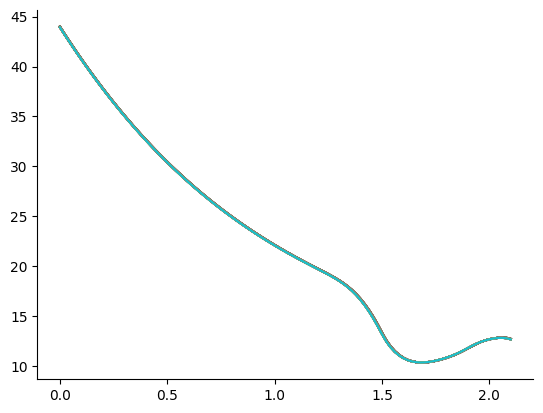

In [15]:
plt.plot(y1_grid_cap, ems)
plt.show()

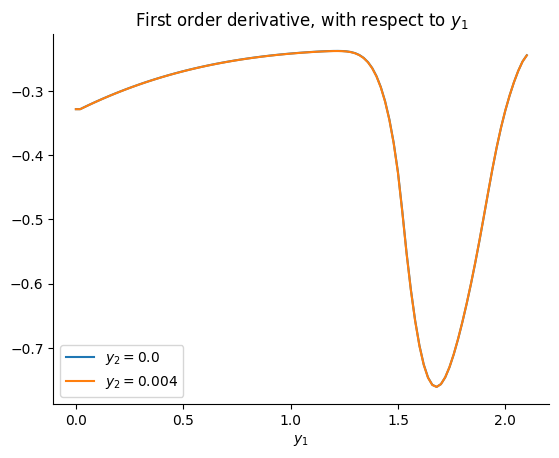

In [16]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

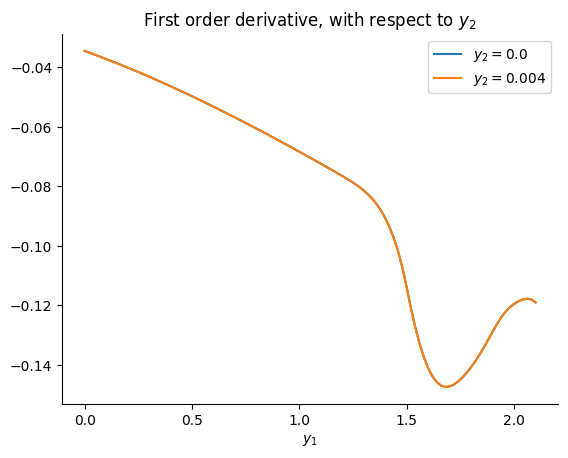

In [17]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

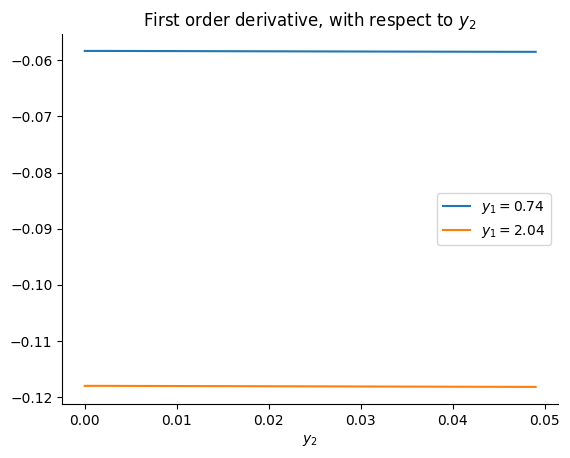

In [18]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

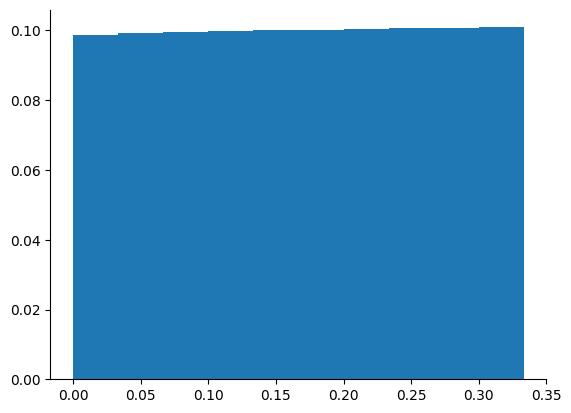

In [19]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

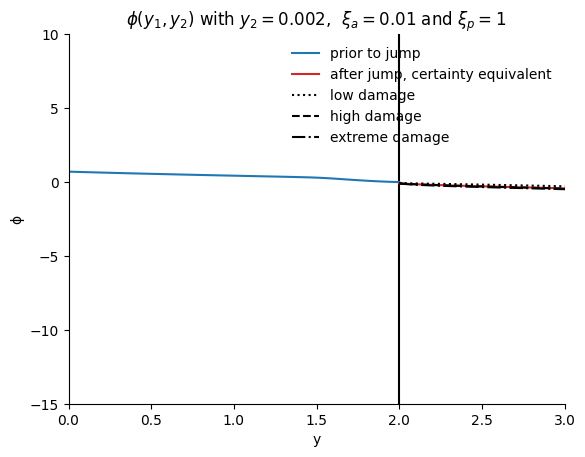

In [20]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

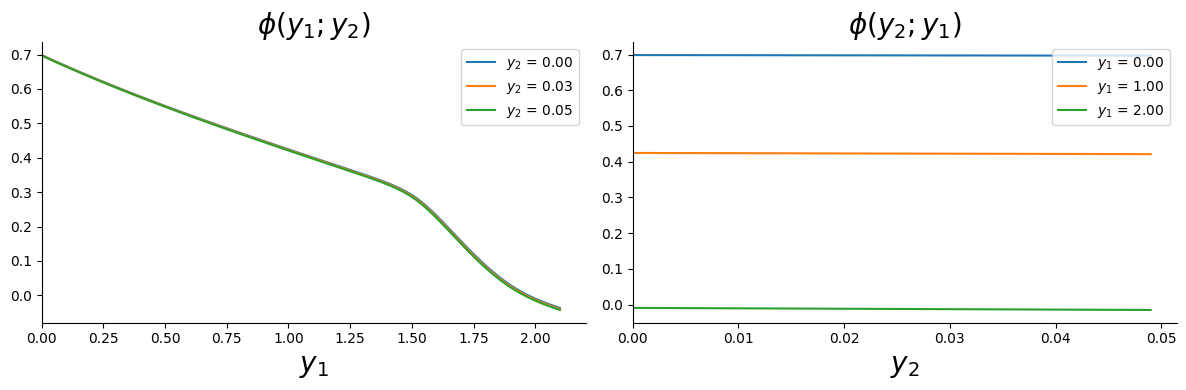

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

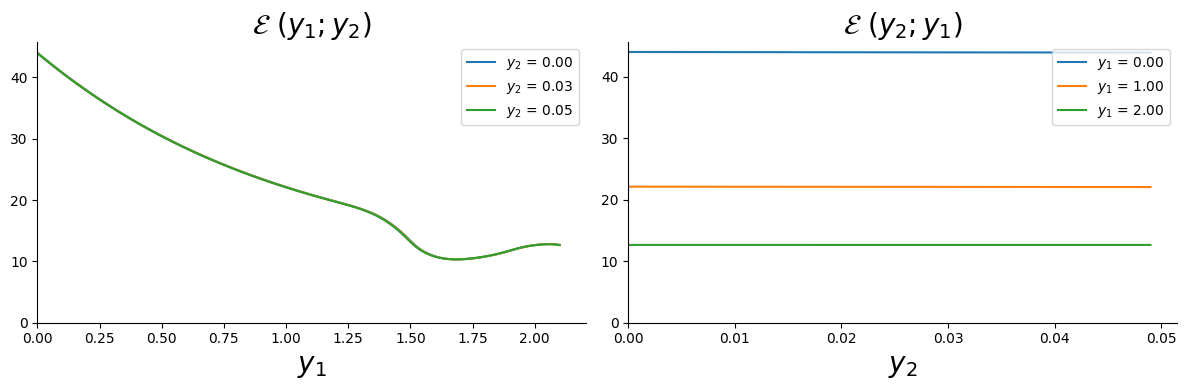

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [23]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [24]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [25]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [26]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [27]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

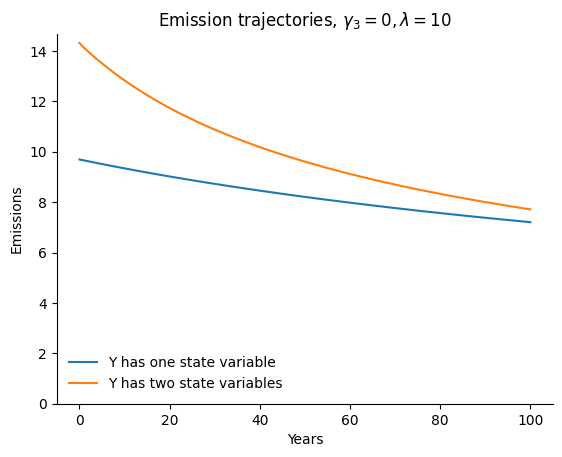

In [28]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [29]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=36
                                                 )

In [30]:
y1t_prejump

array([1.1       , 1.13888626, 1.17685827, 1.21404051, 1.25045866,
       1.28611168, 1.32095501, 1.35488747, 1.38772645, 1.41925439,
       1.44925519, 1.47749223, 1.50382792, 1.52822327, 1.55104289,
       1.57272136, 1.59356693, 1.61380753, 1.63361757, 1.65313453,
       1.67246952, 1.69171408, 1.71094447, 1.73022461, 1.74960814,
       1.76914032, 1.78886029, 1.80880401, 1.82900793, 1.84951261,
       1.8703647 , 1.89161454, 1.91330672, 1.93546469, 1.95807631,
       1.98109167, 2.00443372])

In [31]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

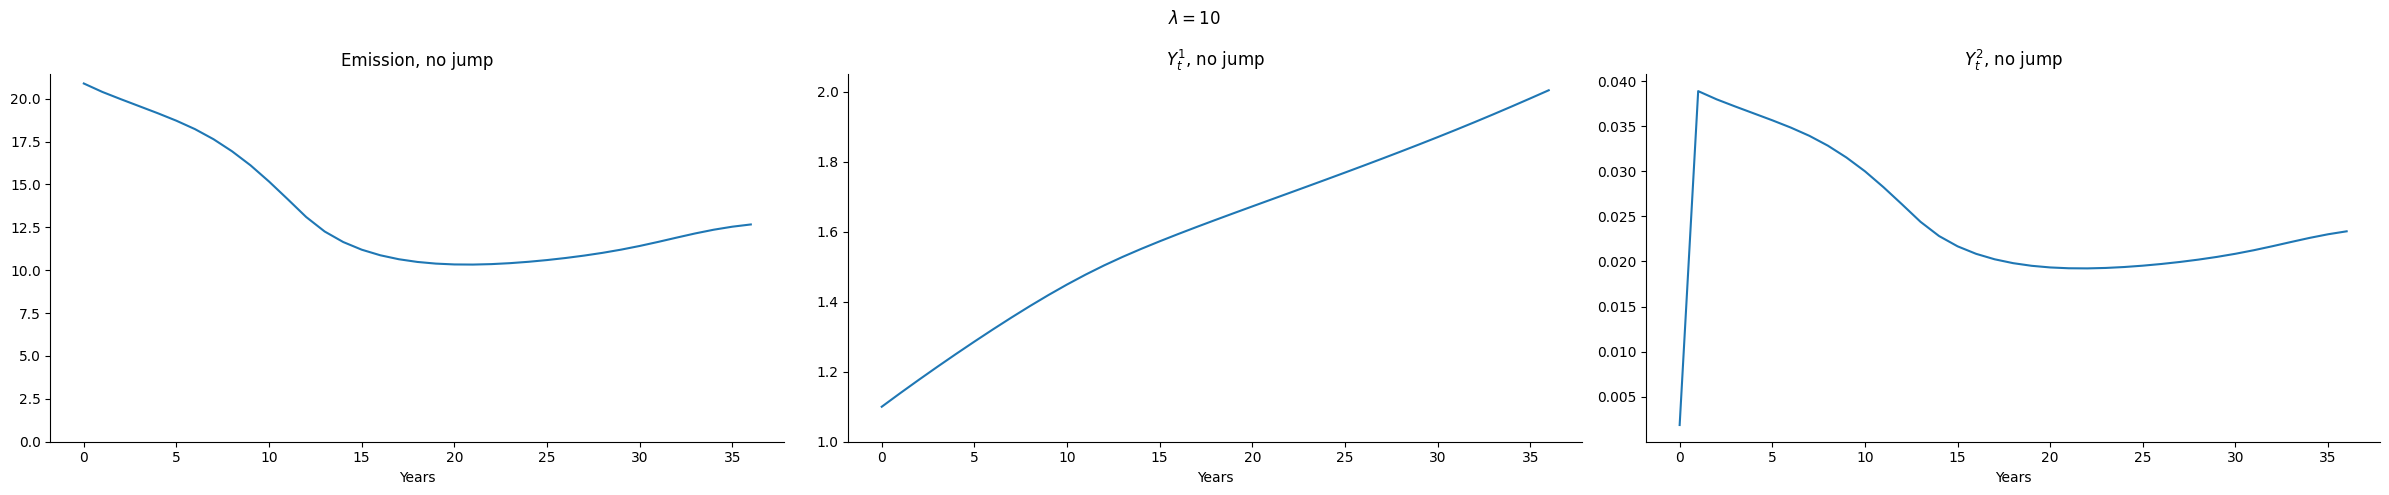

In [32]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$, no jump")
plt.plot(y2t_prejump)
# plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [33]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

In [34]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.03888625693660049,
 0.049,
 array([1.1       , 1.13888626, 1.17685827, 1.21404051, 1.25045866,
        1.28611168, 1.32095501, 1.35488747, 1.38772645, 1.41925439,
        1.44925519, 1.47749223, 1.50382792, 1.52822327, 1.55104289,
        1.57272136, 1.59356693, 1.61380753, 1.63361757, 1.65313453,
        1.67246952, 1.69171408, 1.71094447, 1.73022461, 1.74960814,
        1.76914032, 1.78886029, 1.80880401, 1.82900793, 1.84951261,
        1.8703647 , 1.89161454, 1.91330672, 1.93546469, 1.95807631,
        1.98109167, 2.00443372]))

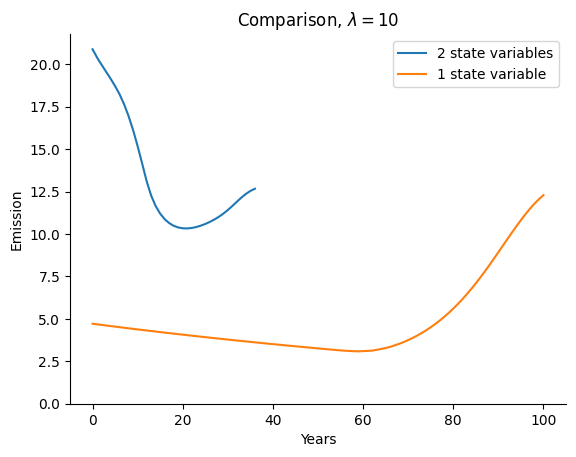

In [35]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [36]:

# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [37]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [39]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=37)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

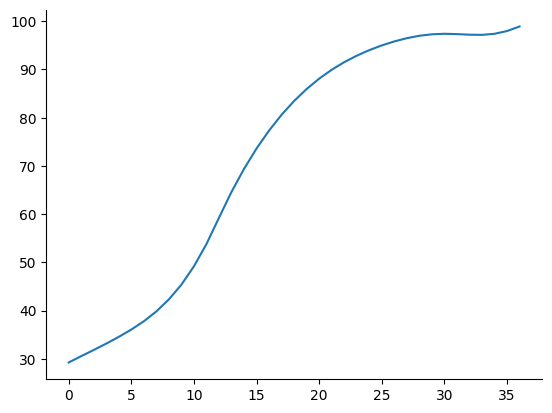

In [40]:
plt.plot(scc)
plt.show()

In [41]:
np.save(f"scct_{λ}", scc)